In [ ]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.layers.core import Dense, Activation, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

def create_dataset(signal_data, look_back=1):
    dataX, dataY = [], []
    for i in range(len(signal_data) - look_back):
        dataX.append(signal_data[i:(i + look_back), 0])
        dataY.append(signal_data[i + look_back, 0])
    return np.array(dataX), np.array(dataY)



look_back = 10

# 1. 데이터셋 생성하기
#signal_data = np.cos(np.arange(1600) * (20 * np.pi / 1000))[:, None]
df = pd.read_csv('test.csv')
signal_data = df.Close.values.astype('float32')
signal_data = signal_data.reshape(len(df), 1)

scaler = MinMaxScaler(feature_range=(0, 1))
signal_data = scaler.fit_transform(signal_data)


train_size = int(len(signal_data) * 0.80)
test_size = len(signal_data) - train_size
train, test = signal_data[0:train_size,:], signal_data[train_size:len(signal_data),:]

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1 ))

model = Sequential()
model.add(LSTM(32, input_shape=(look_back, 1)))
model.add(Dropout(0.3))
model.add(Dense(1))

# 3. 모델 학습과정 설정하기
model.compile(loss='mean_squared_error', optimizer='adam')

# 4. 모델 학습시키기
hist = model.fit(trainX, trainY, epochs=10, batch_size=16)

# # 6. 모델 평가하기
# trainScore = model.evaluate(trainX, trainY, verbose=0)
# model.reset_states()
# print('Train Score: ', trainScore)
# # valScore = model.evaluate(x_val, y_val, verbose=0)
# model.reset_states()
# # print('Validataion Score: ', valScore)
# testScore = model.evaluate(testX, testY, verbose=0)
# model.reset_states()
# print('Test Score: ', testScore)

Using TensorFlow backend.


Epoch 1/10


In [84]:
print(testX.shape)
print(testY.shape)

(137, 10, 1)
(137,)


In [91]:
print(df.head(5))
print(len(df))

         Date  Close
0  2016-01-01    145
1  2016-01-01    116
2  2016-01-02    288
3  2016-01-02    181
4  2016-01-03    198
732


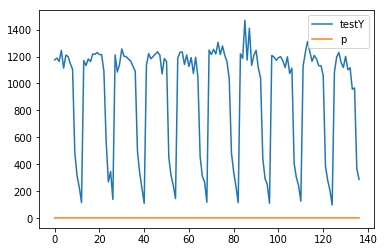

In [86]:
p = model.predict(testX)
plt.plot(testY)
plt.plot(p)
plt.legend(['testY', 'p'], loc='upper right')
plt.show()

In [87]:
p

array([[2.5551279],
       [2.5551279],
       [2.5551279],
       [2.5551279],
       [2.5551279],
       [2.5551279],
       [2.5551279],
       [2.5551279],
       [2.5551279],
       [2.5551279],
       [2.5551279],
       [2.555113 ],
       [2.5549586],
       [2.5508378],
       [2.5551279],
       [2.5551279],
       [2.5551279],
       [2.5551279],
       [2.5551279],
       [2.5551279],
       [2.5551279],
       [2.5551279],
       [2.5551279],
       [2.5551279],
       [2.5551279],
       [2.555074 ],
       [2.555122 ],
       [2.5529087],
       [2.5551279],
       [2.5551279],
       [2.5551279],
       [2.5551279],
       [2.5551279],
       [2.5551279],
       [2.5551279],
       [2.5551279],
       [2.5551279],
       [2.5551279],
       [2.5551279],
       [2.5551198],
       [2.554921 ],
       [2.5500312],
       [2.5551279],
       [2.5551279],
       [2.5551279],
       [2.5551279],
       [2.5551279],
       [2.5551279],
       [2.5551279],
       [2.5551279],


In [52]:
trainX = trainX.reshape(39, 1)

In [1]:
import datetime

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from evaluate_ts import evaluate_ts
from tensorflow.contrib import rnn
from tools import fetch_stock_price, format_dataset

tf.reset_default_graph()
tf.set_random_seed(101)
np.random.seed(101)

# Settings for the dataset creation
symbol = "MSFT"
time_dimension = 20
train_size = 252
test_size = 252 - time_dimension

# Settings for tensorflow
learning_rate = 0.001
optimizer = tf.train.AdagradOptimizer
n_epochs = 100
n_embeddings = 128

if True:  # prod values
    learning_rate = 0.1
    n_epochs = 5000
    n_embeddings = 256

# Fetch the values, and prepare the train/test split
stock_values = fetch_stock_price(symbol, datetime.date(2015, 1, 1), datetime.date(2016, 12, 31))
minibatch_cos_X, minibatch_cos_y = format_dataset(stock_values, time_dimension)

train_X = minibatch_cos_X[:train_size, :].astype(np.float32)
train_y = minibatch_cos_y[:train_size].reshape((-1, 1)).astype(np.float32)
test_X = minibatch_cos_X[train_size:, :].astype(np.float32)
test_y = minibatch_cos_y[train_size:].reshape((-1, 1)).astype(np.float32)

train_X_ts = train_X[:, :, np.newaxis]
test_X_ts = test_X[:, :, np.newaxis]

# Here, the tensorflow code
X_tf = tf.placeholder("float", shape=(None, time_dimension, 1), name="X")
y_tf = tf.placeholder("float", shape=(None, 1), name="y")


# Here the model: a LSTM
def RNN(x, weights, biases):
    x_ = tf.unstack(x, time_dimension, 1)
    lstm_cell = rnn.BasicLSTMCell(n_embeddings)
    outputs, _ = rnn.static_rnn(lstm_cell, x_, dtype=tf.float32)
    return tf.add(biases, tf.matmul(outputs[-1], weights))


# Store layers weight & bias
weights = tf.Variable(tf.truncated_normal([n_embeddings, 1], mean=0.0, stddev=10.0), name="weights")
biases = tf.Variable(tf.zeros([1]), name="bias")


# Model, cost and optimizer
y_pred = RNN(X_tf, weights, biases)
cost = tf.reduce_mean(tf.square(y_tf - y_pred))
train_op = optimizer(learning_rate).minimize(cost)


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    # For each epoch, the whole training set is feeded into the tensorflow graph
    for i in range(n_epochs):
        train_cost, _ = sess.run([cost, train_op], feed_dict={X_tf: train_X_ts, y_tf: train_y})
        if i%100 == 0:
            print("Training iteration", i, "MSE", train_cost)

    # After the training, let's check the performance on the test set
    test_cost, y_pr = sess.run([cost, y_pred], feed_dict={X_tf: test_X_ts, y_tf: test_y})
    print("Test dataset:", test_cost)

    # Evaluate the results
    evaluate_ts(test_X, test_y, y_pr)

    # How does the predicted look like?
    plt.plot(range(len(stock_values)), stock_values, 'b')
    plt.plot(range(len(stock_values)-test_size, len(stock_values)), y_pr, 'r--')
    plt.xlabel("Days")
    plt.ylabel("Predicted and true values")
    plt.title("Predicted (Red) VS Real (Blue)")
    plt.show()


ModuleNotFoundError: No module named 'tools'

In [7]:
# 0. 사용할 패키지 불러오기
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.layers.core import Dense, Activation, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.ensemble.forest import RandomForestRegressor
from sklearn.metrics import f1_score, precision_score, confusion_matrix, recall_score, accuracy_score
from sklearn.model_selection import train_test_split

config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
def create_dataset(signal_data, look_back=1):
    dataX, dataY = [], []
    for i in range(len(signal_data) - look_back):
        dataX.append(signal_data[i:(i + look_back), 0])
        dataY.append(signal_data[i + look_back, 0])
    return np.array(dataX), np.array(dataY)


look_back = 1

# 1. 데이터셋 생성하기

df = pd.read_csv('kospi.csv')
signal_data = df.Close.values.astype('float32')
signal_data = signal_data.reshape(len(df), 1)

# 데이터 전처리
# scaler = MinMaxScaler(feature_range=(0, 1))
# signal_data = scaler.fit_transform(signal_data)

# 데이터 분리
# train = signal_data[0:800]
# val = signal_data[800:1200]
# test = signal_data[1200:]
train_size = int(len(signal_data) * 0.80)
test_size = len(signal_data) - train_size - int(len(signal_data) * 0.05)
val_size = len(signal_data) - train_size - test_size
train = signal_data[0:train_size]
val = signal_data[train_size:train_size+val_size]
test = signal_data[train_size+val_size:len(signal_data)]
# train, test = stock_price[0:train_size,:], stock_price[train_size:len(stock_price),:]

# 데이터셋 생성
x_train, y_train = create_dataset(train, look_back)
x_val, y_val = create_dataset(val, look_back)
x_test, y_test = create_dataset(test, look_back)

# 데이터셋 전처리
# x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1]))
# x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1]))
# x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1]))

# 2. 모델 구성하기
# LSTM

In [9]:
train_size

40

In [5]:
test.shape

(8, 1)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(train, test, train_size = 0.8)

RF_Model = RandomForestRegressor(n_estimators=100,
                                 max_features=1, oob_score=True)
rgr=RF_Model.fit(x_train, y_train)
X_test_predict = pd.DataFrame(
    rgr.predict(x_test[:, None])).rename(
    columns={0: 'predicted_price'}).set_index('predicted_price')
X_train_predict = pd.DataFrame(
    rgr.predict(x_test[:, None])).rename(
    columns={0: 'predicted_price'}).set_index('predicted_price')

df[['price', 'predicted_price']].plot()